<a href="https://colab.research.google.com/github/OussemaOmri/Demand-forecasting-with-ARIMA-and-LSTM/blob/main/ARIMA_%26_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pmdarima


  Using cached pmdarima-1.8.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.4 MB)
  Using cached statsmodels-0.13.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)


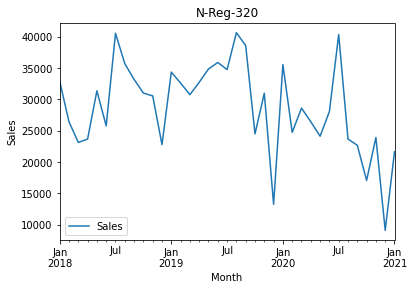

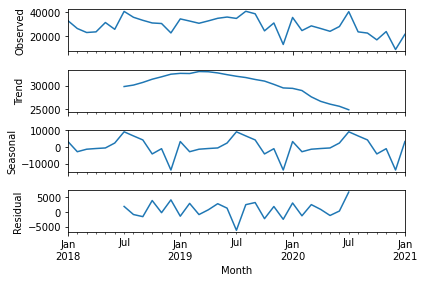


ADF test:
ADF Statistic : -1.8273166709463327
p-value : 0.3669865173871337
critical values :
	1%: -3.6327426647230316
	5%: -2.9485102040816327
	10%: -2.6130173469387756


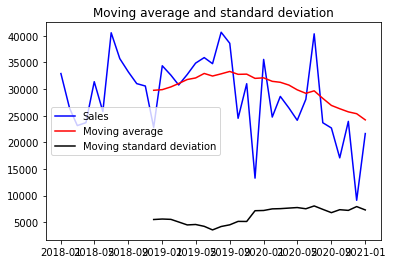


ADF test results after differenciation:
Statistic ADF : -11.501205709892213
p-value : 4.487143754568865e-21
critical values :
	1%: -3.6327426647230316
	5%: -2.9485102040816327
	10%: -2.6130173469387756


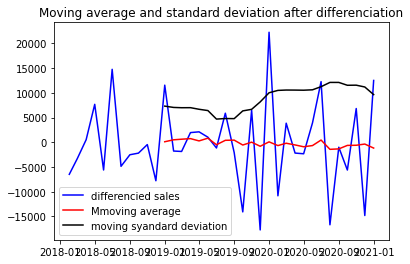

ModuleNotFoundError: ignored

In [ ]:
#importation des biblio
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from sklearn import preprocessing
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from math import sqrt 

# Load in the time series
df = pd.read_csv('N-Reg-320.csv',index_col='Month',parse_dates=True)
# Plot and show the time series on axis ax
fig, ax = plt.subplots()
plt.ylabel('Sales')
plt.title('N-Reg-320')
df.plot(ax=ax)
plt.show()

# Perform additive decomposition
decomp = seasonal_decompose(df, freq=12)
# Plot decomposition
decomp.plot()
plt.show()

# Run test ADF before differenciation
result = adfuller(df["Sales"])
print('\nADF test:')
print('ADF Statistic : {}'.format(result[0]))
print('p-value : {}'.format(result[1]))
print('critical values :')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))
    
#Rolling statistics : Plotting the moving average and moving standard deviation
rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Sales')
plt.plot(rolling_mean, color = 'red', label = 'Moving average')
plt.plot(rolling_std, color = 'black', label = 'Moving standard deviation')
plt.legend(loc = 'best')
plt.title('Moving average and standard deviation')
plt.show()

# Calculate the difference and drop the nans
df_diff = df.diff().dropna()

# Run test and print
result_diff = adfuller(df_diff['Sales'])
print('\nADF test results after differenciation:')
print('Statistic ADF : {}'.format(result_diff[0]))
print('p-value : {}'.format(result_diff[1]))
print('critical values :')
for key, value in result_diff[4].items():
    print('\t{}: {}'.format(key, value))
    
#Rolling statistics : Plotting the moving average and moving standard deviation
rolling_mean = df_diff.rolling(window = 12).mean()
rolling_std = df_diff.rolling(window = 12).std()
plt.plot(df_diff, color = 'blue', label = 'differencied sales')
plt.plot(rolling_mean, color = 'red', label = 'Mmoving average')
plt.plot(rolling_std, color = 'black', label = 'moving syandard deviation')
plt.legend(loc = 'best')
plt.title('Moving average and standard deviation after differenciation')
plt.show()

# Import pmdarima as pm
import pmdarima as pm
model = pm.auto_arima(df,seasonal=True, m=12,d=1,trace=True,error_action='ignore',suppress_warnings=True,
                      information_criterion='aic',stepwise=True)
print(model.summary())

# Create model
arima = SARIMAX(df, order=(0,1,1), seasonal_order=(2,0,0,12))
# Fit model
arima_results = arima.fit()
print(arima_results.summary())

# Generate predictions
one_step_forecast = arima_results.get_prediction(start=-27)
# Extract prediction mean
mean_forecast = one_step_forecast.predicted_mean
# Get confidence intervals of  predictions
confidence_intervals = one_step_forecast.conf_int()
# Select lower and upper confidence limits
lower_limits = confidence_intervals.iloc[:,0]
upper_limits = confidence_intervals.iloc[:,1]

# plot predictions
plt.plot(df.index, df, label='Real_values')
plt.plot(mean_forecast.index, mean_forecast, color='r', label='Predicted_values')
plt.fill_between(lower_limits.index, lower_limits,
		 upper_limits, color='pink', label='Confidence_intervals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid[10:38]))
# Calculate the mean squadret error from residuals
rmse = sqrt(np.mean(np.square(arima_results.resid[10:38])))

# Print the root mean absolute error
print("The mean absolute error is : ",mae)
print("The root mean squart error is : ",rmse)
# Calculate the mean sales
mean_sales=np.mean(df[10:38])[0]
# Print the % of the mean absolute error
print("The % of the mean absolute error is :" ,(mae*100/mean_sales),"%")

# Create the 4 diagnostics plots
arima_results.plot_diagnostics()
plt.show()

# Make ARIMA forecast of next 12 values
arima_value_forecast =arima_results.get_forecast(steps=12).predicted_mean
conf_int=arima_results.get_forecast(steps=12).conf_int()
# Print forecast
print("Predicted mean:\n",arima_value_forecast)
print(arima_results.get_forecast(steps=12).conf_int())

plt.figure()

# Plot past Sales
plt.plot(df.index, df, label='past')

# Plot the prediction means as line
plt.plot(arima_value_forecast.index, arima_value_forecast, label='predicted')

# Shade between the confidence intervals
plt.fill_between(arima_value_forecast.index, conf_int.iloc[:,0], conf_int.iloc[:,1], alpha=0.2)

# Plot legend and show figure
plt.ylabel("Sales")
plt.legend()
plt.show() 

# plot residual erros
residuals = pd.DataFrame(arima_results.resid)
print(residuals)
residuals.plot()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())




In [ ]:
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from __future__ import division

import warnings
warnings.filterwarnings("ignore")

import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

#import Keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

In [ ]:
#read the data in csv
df_sales = pd.read_csv('N-Reg-320.csv')
df_sales.head(37)

,Month,Residuals
0,2018-01-01,32900.000000
1,2018-02-01,7030.534936
2,2018-03-01,225.453856
3,2018-04-01,656.935469
4,2018-05-01,8039.895818
5,2018-06-01,-1320.640164
6,2018-07-01,14070.538724
7,2018-08-01,2636.305372
8,2018-09-01,-1106.230904
9,2018-10-01,-2769.634608


In [ ]:
#convert date field from string to datetime
df_sales['Month'] = pd.to_datetime(df_sales['Month'])

#show first 10 rows
df_sales.head(10)

,Month,Residuals
0,2018-01-01,32900.000000
1,2018-02-01,7030.534936
2,2018-03-01,225.453856
3,2018-04-01,656.935469
4,2018-05-01,8039.895818
5,2018-06-01,-1320.640164
6,2018-07-01,14070.538724
7,2018-08-01,2636.305372
8,2018-09-01,-1106.230904
9,2018-10-01,-2769.634608


In [ ]:
#plot monthly residuals
plot_data = [
    go.Scatter(
        x=df_sales['Month'],
        y=df_sales['Residuals'],
    )
]
plot_layout = go.Layout(
        title='Montly Residuals'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

In [ ]:
#create a new dataframe to model the difference
df_diff = df_sales.copy()
#add previous sales to the next row
df_diff['prev_residuals'] = df_diff['Residuals'].shift(1)
#drop the null values and calculate the difference
df_diff = df_diff.dropna()
df_diff['diff'] = (df_diff['Residuals'] - df_diff['prev_residuals'])
df_diff.head(37)

,Month,Residuals,prev_residuals,diff
1,2018-02-01,7030.534936,32900.000000,-25869.465064
2,2018-03-01,225.453856,7030.534936,-6805.081080
3,2018-04-01,656.935469,225.453856,431.481613
4,2018-05-01,8039.895818,656.935469,7382.960349
5,2018-06-01,-1320.640164,8039.895818,-9360.535982
6,2018-07-01,14070.538724,-1320.640164,15391.178888
7,2018-08-01,2636.305372,14070.538724,-11434.233352
8,2018-09-01,-1106.230904,2636.305372,-3742.536276
9,2018-10-01,-2769.634608,-1106.230904,-1663.403704
10,2018-11-01,-1925.754626,-2769.634608,843.879982


In [ ]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_residuals'],axis=1)
#adding lags
for inc in range(1,13):
    field_name = 'lag_' + str(inc)
    df_supervised[field_name] = df_supervised['diff'].shift(inc)
#drop null values
df_supervised = df_supervised.dropna().reset_index(drop=True)

In [ ]:
df_supervised.head(10)
# Import statsmodels.formula.api
import statsmodels.formula.api as smf
# Define the regression formula
model = smf.ols(formula='diff ~ lag_1+lag_2+lag_3+lag_4+lag_5+lag_5+lag_6+lag_7+lag_8+lag_9+lag_10+lag_11+lag_12', data=df_supervised)
# Fit the regression
model_fit = model.fit()
# Extract the adjusted r-squared
regression_adj_rsq = model_fit.rsquared_adj
print(regression_adj_rsq)

0.5932159097533274


In [ ]:
#import MinMaxScaler and create a new dataframe for ann model
from sklearn.preprocessing import MinMaxScaler
df_model = df_supervised.drop(['Residuals','Month'],axis=1)
#split train and test set
train_set, test_set = df_model[0:-12].values, df_model[-12:].values

In [ ]:
#apply Min Max Scaler
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)
# reshape training set
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
train_set_scaled = scaler.transform(train_set)
# reshape test set
test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
test_set_scaled = scaler.transform(test_set)

In [ ]:
X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1]
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1, shuffle=False)

Epoch 1/100
12/12 [==============================] - 1s 2ms/step - loss: 0.3879
Epoch 2/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3793
Epoch 3/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3621
Epoch 4/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3471
Epoch 5/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3347
Epoch 6/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3246
Epoch 7/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3160
Epoch 8/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3087
Epoch 9/100
12/12 [==============================] - 0s 2ms/step - loss: 0.3024
Epoch 10/100
12/12 [==============================] - 0s 2ms/step - loss: 0.2967
Epoch 11/100
12/12 [==============================] - 0s 2ms/step - loss: 0.2916
Epoch 12/100
12/12 [==============================] - 0s 2ms/step - loss: 0.2870
Epoch 13/100
12/12 [=================

In [ ]:
y_pred = model.predict(X_test,batch_size=1)
#for multistep prediction, you need to replace X_test values with the predictions coming from t-1
#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    print (np.concatenate([y_pred[index],X_test[index]],axis=1))
    pred_test_set.append(np.concatenate([y_pred[index],X_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

[[-0.31166354  1.19115313 -0.76512419  1.23795496 -1.74210162 -0.53781571
   1.95708007 -0.71525302  0.06469033 -0.23181867  0.01487286 -0.19415182
   0.30502029]]
[[-0.62425256 -0.72357899  1.19115313 -0.73717926  1.32624835 -1.74210162
   0.09464036  0.57418729 -0.71525302  0.06469033 -0.23181867  0.01487286
   0.22362785]]
[[ 0.46687987  0.68133137 -0.72357899  1.45185101 -1.38176103  1.32624835
  -1.36386334 -0.41727349  0.57418729 -0.71525302  0.06469033 -0.23181867
   0.35952425]]
[[-0.82180971 -0.22453253  0.68133137 -0.69069111  1.61951069 -1.38176103
   2.35219756 -1.19370089 -0.41727349  0.57418729 -0.71525302  0.06469033
   0.19913893]]
[[ 0.71035504 -0.27188914 -0.22453253  0.88137195 -1.31802342  1.61951069
  -0.92745693  0.78452617 -1.19370089 -0.41727349  0.57418729 -0.71525302
   0.39191285]]
[[-0.3975189   0.68172264 -0.27188914 -0.13226936  0.83735491 -1.31802342
   2.70736589 -0.96138205  0.78452617 -1.19370089 -0.41727349  0.57418729
  -0.11516363]]
[[ 0.59751147  0

In [ ]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[24:].Month)
act_sales = list(df_sales[24:].Residuals)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
#for multistep prediction, replace act_sales with the predicted sales

In [ ]:
df_result



,pred_value,date
0,72,2020-02-01
1,-14835,2020-03-01
2,9296,2020-04-01
3,-13178,2020-05-01
4,4718,2020-06-01
5,-3105,2020-07-01
6,18339,2020-08-01
7,-4640,2020-09-01
8,-6730,2020-10-01
9,-10052,2020-11-01
